# Project #3
_____

# Data Cleaning and Exploratory Analysis
> Author: Si|via Resende

---

Null and invalid values such as 'delete', 'Title' and 'Title.' have been removed from the dataset of the columns used in question. In a later step, it was noticed that links from several sites occurred with a certain frequency and given that we will be using NPL for the analysis of this data, and as these links do not add value or information to the model, we remove them and put them in a new column so that they can be processed in future works.


After, it was noticed that links from several sites occurred with a certain frequency and given that we will be using NPL for the analysis of this data, and as these links do not add value or information to the model, we remove them and put them in a new column so that they can be processed in future works. For language processing (NPL) we used several modules from the NLTK library such as word_tokenize, RegexpTokenizer, WordNetLemmatizer, and PorterStemmer. As the last step of data cleaning, we remove outliers and binarize our target.

#### Importing Libraries

In [793]:
# Importing Libraries
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Libraries for NPL
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [794]:
# Reading and Checking Data 
subreddits = pd.read_csv('../data/subreddits_.csv')
subreddits.drop(columns='Unnamed: 0', inplace=True)
subreddits.shape

(6137, 73)

In [795]:
subreddits.head(3)

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,...,url,whitelist_status,wls,author_cakeday,author_flair_background_color,author_flair_text_color,author_flair_template_id,banned_by,call_to_action,category
0,[],False,--BlueDiamond--,NaN,[],NaN,text,t2_e2ej5jrx,False,False,...,https://www.reddit.com/r/OutOfTheLoop/comments...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,-1-1-1-1-1-1,NaN,[],NaN,text,t2_5n5g2a13,False,False,...,https://www.reddit.com/r/explainlikeimfive/com...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,-Aces_High-,NaN,[],NaN,text,t2_1g0oz2oy,False,False,...,https://www.reddit.com/r/OutOfTheLoop/comments...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [796]:
# Checking Duplicates
subreddits.duplicated().sum()

0

In [797]:
# Dropping for 'selftext'
df = subreddits[['subreddit','selftext']]
df.shape

(6137, 2)

In [798]:
# Checking in nulls
df.isnull().sum()

subreddit       0
selftext     1703
dtype: int64

In [799]:
# Deleting it
df.dropna(inplace=True)
df.shape

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_92448/2053667463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


(4434, 2)

In [800]:
# Dropping invalid Values
df.drop(df[df['selftext']=='[deleted]'].index, inplace=True)
df.drop(df[df['selftext']=='Title'].index, inplace=True)
df.drop(df[df['selftext']=='Title.'].index, inplace=True)

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_92448/898989616.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['selftext']=='[deleted]'].index, inplace=True)
/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_92448/898989616.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['selftext']=='Title'].index, inplace=True)
/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_92448/898989616.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [801]:
# Reseting Index 
df.reset_index(drop=True, inplace=True)

In [802]:
# Checking for Data Balance
df['subreddit'].value_counts()

OutOfTheLoop         2478
explainlikeimfive    1945
Name: subreddit, dtype: int64

In [803]:
df['subreddit'].value_counts(normalize=True)

OutOfTheLoop         0.560253
explainlikeimfive    0.439747
Name: subreddit, dtype: float64

In [804]:
df.head()

,subreddit,selftext
0,OutOfTheLoop,"Last I heard a few years back, she pleaded gui..."
1,explainlikeimfive,So a year ago around I saw a list showing the ...
2,OutOfTheLoop,I've seen memes of people in Martha's Vineyard...
3,OutOfTheLoop,https://youtu.be/56JoCyTTVeY\n\nThere's a lot ...
4,OutOfTheLoop,I found out there're 23 banned subreddits name...


###  Links in 'selftext' content
Let's extract General links from selftext and keep the information for future models (maybe they can contain valuable information)

In [806]:
### Extracting links from 'selftext'
# Defining a tokenizer to get all links
tokenizer_links = RegexpTokenizer(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])')

# Creating a new column to keep these links
df['links'] = df['selftext'].map( lambda x: tokenizer_links.tokenize(x) )

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_92448/125400404.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['links'] = df['selftext'].map( lambda x: tokenizer_links.tokenize(x) )


In [807]:
df.head()

,subreddit,selftext,links
0,OutOfTheLoop,"Last I heard a few years back, she pleaded gui...","[(https, bleacherreport.com, /articles/2446693..."
1,explainlikeimfive,So a year ago around I saw a list showing the ...,[]
2,OutOfTheLoop,I've seen memes of people in Martha's Vineyard...,"[(https, www.reddit.com, /r/PublicFreakout/com..."
3,OutOfTheLoop,https://youtu.be/56JoCyTTVeY\n\nThere's a lot ...,"[(https, youtu.be, /56JoCyTTVeY)]"
4,OutOfTheLoop,I found out there're 23 banned subreddits name...,"[(https, www.reddit.com, /r/mgtow1/), (https, ..."


### Extracting YouTube links from 'selftext'
Youtube has a espefic API to access its data. Let's separate youtube links from others for future works.

In [808]:
# Defining a tokenizer to get Youtube links
tokenizer_ytb = RegexpTokenizer(r'https://youtu.be/\w+')

# Creating a column to keep these links
df['youtube_links'] = df['selftext'].map( lambda x: tokenizer_ytb.tokenize(x))

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_92448/1914220513.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['youtube_links'] = df['selftext'].map( lambda x: tokenizer_ytb.tokenize(x) )


In [809]:
df.head()

,subreddit,selftext,links,youtube_links
0,OutOfTheLoop,"Last I heard a few years back, she pleaded gui...","[(https, bleacherreport.com, /articles/2446693...",[]
1,explainlikeimfive,So a year ago around I saw a list showing the ...,[],[]
2,OutOfTheLoop,I've seen memes of people in Martha's Vineyard...,"[(https, www.reddit.com, /r/PublicFreakout/com...",[]
3,OutOfTheLoop,https://youtu.be/56JoCyTTVeY\n\nThere's a lot ...,"[(https, youtu.be, /56JoCyTTVeY)]",[https://youtu.be/56JoCyTTVeY]
4,OutOfTheLoop,I found out there're 23 banned subreddits name...,"[(https, www.reddit.com, /r/mgtow1/), (https, ...",[]


## PreProcessing 'selftext' content
___

In [810]:
# Creating a new column df['tokens'] for processed document so we keep the original raw document

# Removing links in general 
df['tokens'] = df['selftext'].str.replace(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=;%&:\/~+#-]*[\w@?^=;%&\/~+#-])', '', regex=True);

# Removing \n [] () _ / /r/ \d+
df['tokens'] = df['tokens'].str.replace(r'\n', '', regex=True);
df['tokens'] = df['tokens'].str.replace(r'\[.*?\]', '', regex=True);
df['tokens'] = df['tokens'].str.replace(r'\(.*?\)', '', regex=True);
df['tokens'] = df['tokens'].str.replace(r'\_', ' ', regex=True);
df['tokens'] = df['tokens'].str.replace(r'\/', ' ', regex=True);
df['tokens'] = df['tokens'].str.replace(r'\/r/', ' ', regex=True);
df['tokens'] = df['tokens'].str.replace(r'\d+', '', regex=True);

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_92448/859744674.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['selftext'].str.replace(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=;%&:\/~+#-]*[\w@?^=;%&\/~+#-])', '', regex=True)
/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_92448/859744674.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['tokens'].str.replace(r'\n', '', regex=True)
/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000

In [811]:
# getting just words (Removing punctuation, emicomn/emoji, extra spaces
#  \w+ matches one or more word characters (same as [a-zA-Z0-9_]+ )
tokenizer_w = RegexpTokenizer(r'\w+')

# Turning selftext content into tokens
df['tokens'] = df['tokens'].map( lambda x: tokenizer_w.tokenize(x))


/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_92448/4062840451.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['tokens'].map( lambda x: tokenizer_w.tokenize(x))


In [812]:
df.head(10)

,subreddit,selftext,links,youtube_links,tokens
0,OutOfTheLoop,"Last I heard a few years back, she pleaded gui...","[(https, bleacherreport.com, /articles/2446693...",[],"[Last, I, heard, a, few, years, back, she, ple..."
1,explainlikeimfive,So a year ago around I saw a list showing the ...,[],[],"[So, a, year, ago, around, I, saw, a, list, sh..."
2,OutOfTheLoop,I've seen memes of people in Martha's Vineyard...,"[(https, www.reddit.com, /r/PublicFreakout/com...",[],"[I, ve, seen, memes, of, people, in, Martha, s..."
3,OutOfTheLoop,https://youtu.be/56JoCyTTVeY\n\nThere's a lot ...,"[(https, youtu.be, /56JoCyTTVeY)]",[https://youtu.be/56JoCyTTVeY],"[There, s, a, lot, of, memes, online, by, now,..."
4,OutOfTheLoop,I found out there're 23 banned subreddits name...,"[(https, www.reddit.com, /r/mgtow1/), (https, ...",[],"[I, found, out, there, re, banned, subreddits,..."
5,OutOfTheLoop,[Tweet from The Act Man](https://twitter.com/T...,"[(https, twitter.com, /TheActMan_YT/status/153...",[],"[All, I, can, see, is, stuff, about, Quantum, ..."
6,OutOfTheLoop,I scrolled through a few posts such as these 3...,"[(https, www.reddit.com, /r/OutOfTheLoop/comme...",[],"[I, scrolled, through, a, few, posts, such, as..."
7,explainlikeimfive,With all the harmful ways we store garbage on ...,[],[],"[With, all, the, harmful, ways, we, store, gar..."
8,OutOfTheLoop,I feel like every day I see 1-3 of these in to...,"[(https, i.redd.it, /86i5l4h6k7w81.jpg), (http...",[],"[I, feel, like, every, day, I, see, of, these,..."
9,explainlikeimfive,There's been time where I've gotten so hungry ...,[],[],"[There, s, been, time, where, I, ve, gotten, s..."


In [813]:
# Looking through cleaned selftext content
for i in range(1,10,1):
    print(f'Index:{i}, {df["tokens"].iloc[i]}')

Index:1, ['So', 'a', 'year', 'ago', 'around', 'I', 'saw', 'a', 'list', 'showing', 'the', 'most', 'watched', 'events', 'on', 'TV', 'but', 'I', 'don', 't', 'understand', 'how', 'could', 'anyone', 'find', 'out', 'how', 'many', 'TV', 's', 'have', 'a', 'certain', 'event', 'on']
Index:2, ['I', 've', 'seen', 'memes', 'of', 'people', 'in', 'Martha', 's', 'Vineyard', 'accepting', 'immigrants', 'And', 'I', 'honestly', 'don', 't', 'know', 'what', 's', 'happening', 'but', 'it', 'seems', 'huge']
Index:3, ['There', 's', 'a', 'lot', 'of', 'memes', 'online', 'by', 'now', 'and', 'I', 'm', 'clueless']
Index:4, ['I', 'found', 'out', 'there', 're', 'banned', 'subreddits', 'named', 'from', 'MGTOW', 'to', 'MGTOW', 'I', 'don', 't', 'know', 'precisely', 'why', 'the', 'original', 'got', 'banned', 'but', 'why', 'the', 'persistence', 'both', 'by', 'the', 'community', 'and', 'reddit', 'administration', 'to', 'keep', 'banning', 'them', 'Note', 'not', 'all', 'subs', 'ban', 'reason', 'is', 'specified', 'as', 'ban', 

In [814]:
df['tokens'].isnull().sum()

0

In [815]:
# Checking data types after tokenizing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4423 entries, 0 to 4422
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   subreddit      4423 non-null   object
 1   selftext       4423 non-null   object
 2   links          4423 non-null   object
 3   youtube_links  4423 non-null   object
 4   tokens         4423 non-null   object
dtypes: object(5)
memory usage: 172.9+ KB


In [816]:
# Dropping empty arrays in tokens
df.drop(df[df['tokens'].astype(str) == '[]' ].index, axis=0, inplace=True)

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_92448/985186839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['tokens'].astype(str) == '[]' ].index, axis=0, inplace=True)


### Stemming
____

In [818]:
# Intantiating Stemming
p_stemmer = PorterStemmer()

# Stem tokens.
df['tokens'] = df['tokens'].map( lambda x: [p_stemmer.stem(i) for i in x])

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_92448/993758350.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['tokens'].map( lambda x: [p_stemmer.stem(i) for i in x])


In [819]:
# Quick Looking through stemmed selftext content
for i in range(1,10,1):
    print(f'Index:{i}, {df["tokens"].iloc[i]}')

Index:1, ['so', 'a', 'year', 'ago', 'around', 'i', 'saw', 'a', 'list', 'show', 'the', 'most', 'watch', 'event', 'on', 'tv', 'but', 'i', 'don', 't', 'understand', 'how', 'could', 'anyon', 'find', 'out', 'how', 'mani', 'tv', 's', 'have', 'a', 'certain', 'event', 'on']
Index:2, ['i', 've', 'seen', 'meme', 'of', 'peopl', 'in', 'martha', 's', 'vineyard', 'accept', 'immigr', 'and', 'i', 'honestli', 'don', 't', 'know', 'what', 's', 'happen', 'but', 'it', 'seem', 'huge']
Index:3, ['there', 's', 'a', 'lot', 'of', 'meme', 'onlin', 'by', 'now', 'and', 'i', 'm', 'clueless']
Index:4, ['i', 'found', 'out', 'there', 're', 'ban', 'subreddit', 'name', 'from', 'mgtow', 'to', 'mgtow', 'i', 'don', 't', 'know', 'precis', 'whi', 'the', 'origin', 'got', 'ban', 'but', 'whi', 'the', 'persist', 'both', 'by', 'the', 'commun', 'and', 'reddit', 'administr', 'to', 'keep', 'ban', 'them', 'note', 'not', 'all', 'sub', 'ban', 'reason', 'is', 'specifi', 'as', 'ban', 'evas']
Index:5, ['all', 'i', 'can', 'see', 'is', 'stu

## Exploratory Data Analysis 

Before we even vectorize the text, we might look at the lengths and word counts in each selftext post.

#### Create a new column called `status_length` that contains the length of each status:

In [820]:
df['selftext_length'] = df['selftext'].str.len()
df.head(3)

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_92448/3616962216.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['selftext_length'] = df['selftext'].str.len()


,subreddit,selftext,links,youtube_links,tokens,selftext_length
0,OutOfTheLoop,"Last I heard a few years back, she pleaded gui...","[(https, bleacherreport.com, /articles/2446693...",[],"[last, i, heard, a, few, year, back, she, plea...",218
1,explainlikeimfive,So a year ago around I saw a list showing the ...,[],[],"[so, a, year, ago, around, i, saw, a, list, sh...",161
2,OutOfTheLoop,I've seen memes of people in Martha's Vineyard...,"[(https, www.reddit.com, /r/PublicFreakout/com...",[],"[i, ve, seen, meme, of, peopl, in, martha, s, ...",350


#### Create a new column called `status_word_count` that contains the number of words in each selftext


In [821]:
# Creating column Word Count
df['selftext_word_count'] = df['selftext'].str.split(' ').apply(len)
df.head()

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_92448/4272011286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['selftext_word_count'] = df['selftext'].str.split(' ').apply(len)


,subreddit,selftext,links,youtube_links,tokens,selftext_length,selftext_word_count
0,OutOfTheLoop,"Last I heard a few years back, she pleaded gui...","[(https, bleacherreport.com, /articles/2446693...",[],"[last, i, heard, a, few, year, back, she, plea...",218,18
1,explainlikeimfive,So a year ago around I saw a list showing the ...,[],[],"[so, a, year, ago, around, i, saw, a, list, sh...",161,33
2,OutOfTheLoop,I've seen memes of people in Martha's Vineyard...,"[(https, www.reddit.com, /r/PublicFreakout/com...",[],"[i, ve, seen, meme, of, peopl, in, martha, s, ...",350,21
3,OutOfTheLoop,https://youtu.be/56JoCyTTVeY\n\nThere's a lot ...,"[(https, youtu.be, /56JoCyTTVeY)]",[https://youtu.be/56JoCyTTVeY],"[there, s, a, lot, of, meme, onlin, by, now, a...",84,11
4,OutOfTheLoop,I found out there're 23 banned subreddits name...,"[(https, www.reddit.com, /r/mgtow1/), (https, ...",[],"[i, found, out, there, re, ban, subreddit, nam...",426,46


### Longest and shortest selftext

Looking at individual observations can help us get a sense of what the dataset contains.

#### Show the five longest and five shortest selftext based off of `status_word_count`:

In [822]:
# Shortest statuses
df[df['subreddit']=='OutOfTheLoop'].nsmallest(10, ['selftext_word_count'])

,subreddit,selftext,links,youtube_links,tokens,selftext_length,selftext_word_count
530,OutOfTheLoop,Examples:[https://www.tiktok.com/@achric/video...,"[(https, www.tiktok.com, /@achric/video/712698...",[],[exampl],429,1
951,OutOfTheLoop,[https://www.reddit.com/r/Cringetopia/comments...,"[(https, www.reddit.com, /r/Cringetopia/commen...",[],"[amp, xb]",246,1
362,OutOfTheLoop,Example: https://www.reddit.com/r/xboxone/comm...,"[(https, www.reddit.com, /r/xboxone/comments/u...",[],[exampl],143,2
558,OutOfTheLoop,Example: [https://www.reddit.com/r/place/comme...,"[(https, www.reddit.com, /r/place/comments/tw3...",[],[exampl],208,2
884,OutOfTheLoop,Example: https://www.reddit.com/r/Minecraftbui...,"[(https, www.reddit.com, /r/Minecraftbuilds/co...",[],[exampl],193,2
1063,OutOfTheLoop,https://www.reddit.com/r/Cringetopia/comments/...,"[(https, www.reddit.com, /r/Cringetopia/commen...",[],"[for, refer]",92,2
2255,OutOfTheLoop,https://www.reddit.com/r/MURICA/comments/vu2lr...,"[(https, www.reddit.com, /r/MURICA/comments/vu...",[],[sourc],164,2
2419,OutOfTheLoop,Example: https://images.app.goo.gl/XYMYdAsghHe...,"[(https, images.app.goo.gl, /XYMYdAsghHegh7kGA)]",[],[exampl],52,2
3652,OutOfTheLoop,Context: https://www.bbc.com/news/business-613...,"[(https, www.bbc.com, /news/business-61332272....",[],[context],55,2
3683,OutOfTheLoop,[https://i.imgur.com/FhKvbT0.png](https://i.im...,"[(https, i.imgur.com, /FhKvbT0.png), (https, i...",[],[thank],75,2


In [823]:
# Longest statuses:
df[df['subreddit']=='OutOfTheLoop'].nlargest(10, ['selftext_word_count'])

,subreddit,selftext,links,youtube_links,tokens,selftext_length,selftext_word_count
716,OutOfTheLoop,I don’t understand streamer/influencer culture...,"[(https, m.youtube.com, /watch?v=E_F5GxCwizc),...",[],"[i, don, t, understand, streamer, influenc, cu...",4255,631
715,OutOfTheLoop,So - full disclosure - as a millennial with a ...,"[(https, m.youtube.com, /watch?v=E_F5GxCwizc),...",[],"[so, full, disclosur, as, a, millenni, with, a...",4179,624
3987,OutOfTheLoop,I’m trying to explain to my mom this stereotyp...,"[(https, imgur.com, /a/FcebQhG), (https, imgur...",[],"[i, m, tri, to, explain, to, my, mom, thi, ste...",3333,571
2083,OutOfTheLoop,This is not meant to be an offensive post. I a...,"[(https, www.thegamer.com, /guilty-gear-strive...",[],"[thi, is, not, meant, to, be, an, offens, post...",3140,483
3623,OutOfTheLoop,"A lot of times, I will have trashy tv on as ba...","[(https, en.wikipedia.org, /wiki/Sovereign_cit...",[],"[a, lot, of, time, i, will, have, trashi, tv, ...",2610,451
935,OutOfTheLoop,Beware: Very NSFW topics ahead (scatology and ...,"[(https, en.memesrandom.com, /porta-potty-duba...",[],"[bewar, veri, nsfw, topic, ahead, i, don, t, k...",2348,390
2745,OutOfTheLoop,"For many many reasons, I have an issue with th...","[(https, www.change.org, /saveincandescents)]",[],"[for, mani, mani, reason, i, have, an, issu, w...",2195,384
1060,OutOfTheLoop,[https://cacm.acm.org/system/assets/0003/5271/...,"[(https, cacm.acm.org, /system/assets/0003/527...",[],"[so, i, ve, been, around, for, year, and, thi,...",2248,349
987,OutOfTheLoop,(Original title: What is the significance of t...,"[(https, www.dailymail.co.uk, /news/article-10...",[],"[note, i, don, t, use, the, internet, much, at...",2018,328
1148,OutOfTheLoop,"This morning, in Dobbs vs. Jackson Womens' Hea...",[],[],"[thi, morn, in, dobb, vs, jackson, women, heal...",2025,323


In [824]:
df[df['subreddit']=='explainlikeimfive'].nsmallest(10, ['selftext_word_count'])

,subreddit,selftext,links,youtube_links,tokens,selftext_length,selftext_word_count
3989,explainlikeimfive,I,[],[],[i],1,1
801,explainlikeimfive,Imaginary numbers.,[],[],"[imaginari, number]",18,2
1059,explainlikeimfive,Just curious,[],[],"[just, curiou]",12,2
2331,explainlikeimfive,I wonder.,[],[],"[i, wonder]",9,2
3941,explainlikeimfive,The title,[],[],"[the, titl]",9,2
4096,explainlikeimfive,What changed,[],[],"[what, chang]",12,2
61,explainlikeimfive,Well I’m clueless,[],[],"[well, i, m, clueless]",17,3
445,explainlikeimfive,Part 1:\nhttps://www.tiktok.com/t/ZTR556D52/\n...,"[(https, www.tiktok.com, /t/ZTR556D52/), (http...",[],"[part, part]",87,3
849,explainlikeimfive,General mechanics/indications—- thanksss:),[],[],"[gener, mechan, indic, thanksss]",42,3
1819,explainlikeimfive,Also stomach etc…,[],[],"[also, stomach, etc]",17,3


In [825]:
df[df['subreddit']=='explainlikeimfive'].nlargest(10, ['selftext_word_count'])

,subreddit,selftext,links,youtube_links,tokens,selftext_length,selftext_word_count
891,explainlikeimfive,"I will try to explain best as I can, everythin...",[],[],"[i, will, tri, to, explain, best, as, i, can, ...",10691,2037
4111,explainlikeimfive,𝐎𝐧𝐞 𝐨𝐟 𝐭𝐡𝐞 𝐛𝐢𝐠𝐠𝐞𝐬𝐭 𝐛𝐨𝐨𝐧𝐬💥 to performance in a ...,[],[],"[𝐎𝐧𝐞, 𝐨𝐟, 𝐭𝐡𝐞, 𝐛𝐢𝐠𝐠𝐞𝐬𝐭, 𝐛𝐨𝐨𝐧𝐬, to, perform, in...",2504,414
2672,explainlikeimfive,I have one credit card - a secured credit card...,[],[],"[i, have, one, credit, card, a, secur, credit,...",2048,375
3702,explainlikeimfive,I read something about how some reptiles and a...,[],[],"[i, read, someth, about, how, some, reptil, an...",1659,297
1604,explainlikeimfive,I was initially reading about AI but went down...,[],[],"[i, wa, initi, read, about, ai, but, went, dow...",1629,284
3427,explainlikeimfive,I don't buy the hippy mumbo jumbo B.S. but I i...,[],[],"[i, don, t, buy, the, hippi, mumbo, jumbo, b, ...",1425,284
608,explainlikeimfive,So the title doesn't do the best job asking my...,[],[],"[so, the, titl, doesn, t, do, the, best, job, ...",1610,277
1656,explainlikeimfive,I just need something explained to me because ...,[],[],"[i, just, need, someth, explain, to, me, becau...",1436,268
274,explainlikeimfive,"I'm a lighting engineer for events (gigs, club...",[],[],"[i, m, a, light, engin, for, event, i, do, som...",1406,263
2250,explainlikeimfive,"\n\nA year and a half ago, I met this guy who ...",[],[],"[a, year, and, a, half, ago, i, met, thi, guy,...",1328,263


## What's the distribution of post lengths?

Distributions of post lengths and word counts in corpus. Both of them are skewed to the rigth.

<Figure size 720x360 with 0 Axes>

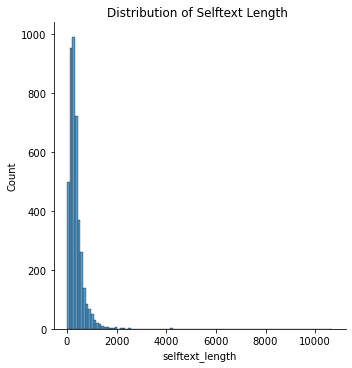

In [826]:
# Plotting Distributions
plt.figure(figsize = (10, 5))
sns.displot(df['selftext_length'], kind = 'hist', bins = 100)
plt.title('Distribution of Selftext Length ');

<Figure size 720x360 with 0 Axes>

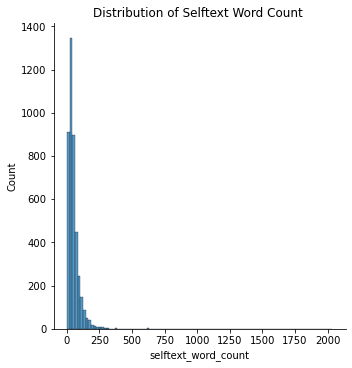

In [827]:
# Plotting
plt.figure(figsize = (10, 5))
sns.displot(df['selftext_word_count'], kind = 'hist', bins = 100)
plt.title('Distribution of Selftext Word Count ');

### Removing Outliers


(4248, 7)

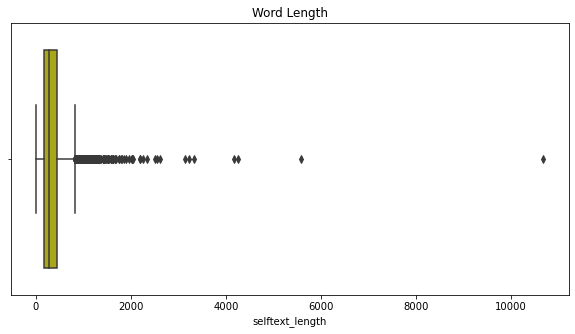

In [828]:
# Checking Outliers
plt.figure(figsize = (10, 5))
plt.title('Word Length')
sns.boxplot(x = df['selftext_length'], color = 'y');
df.shape

(4248, 7)

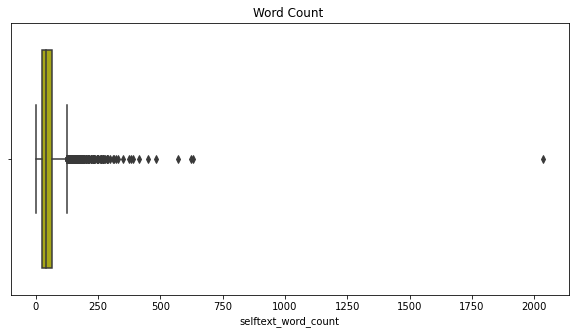

In [829]:
plt.figure(figsize = (10, 5))
plt.title('Word Count ')
sns.boxplot(x = df['selftext_word_count'], color = 'y');
df.shape

In [831]:
# Removing Outliers
Q1 =  df['selftext_word_count'].quantile(0.25)
Q3 =  df['selftext_word_count'].quantile(0.75)
IQR = Q3 - Q1
df.drop(df[df['selftext_word_count'] < (Q1 - 1.5 * IQR)].index, inplace=True)   
df.drop(df[df['selftext_word_count'] > (Q3 + 1.5 * IQR)].index, inplace=True)
df.shape

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_92448/1827809193.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['selftext_word_count'] < (Q1 - 1.5 * IQR)].index, inplace=True)
/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_92448/1827809193.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['selftext_word_count'] > (Q3 + 1.5 * IQR)].index, inplace=True)


(3998, 7)

### Distributions After Removing Outliers
___

<Figure size 720x360 with 0 Axes>

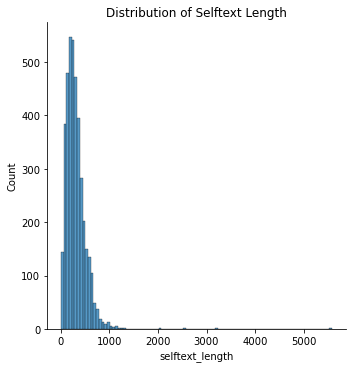

In [870]:
# Checking Plots after removing Outliers
sns.displot(
    df['selftext_length'], 
    kind = 'hist', 
    bins = 100
    ).set(title="Distribution of Selftext Length");

(3998, 7)

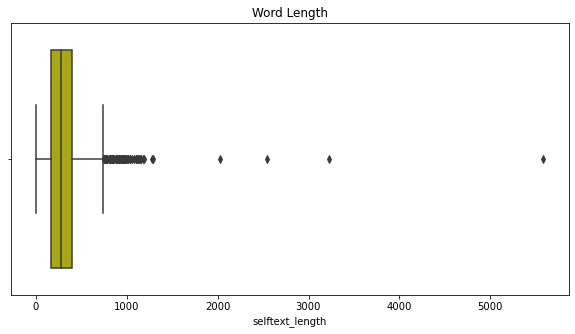

In [833]:
plt.figure(figsize = (10, 5))
plt.title('Word Length')
sns.boxplot(x = df['selftext_length'], color = 'y');
df.shape

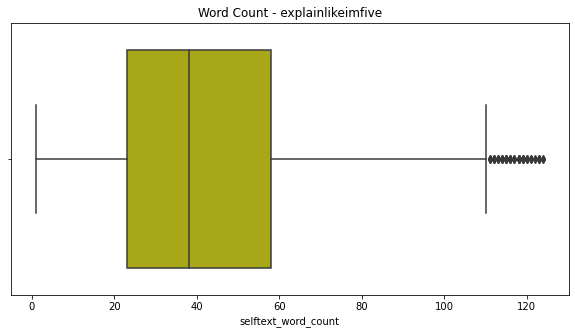

In [834]:
plt.figure(figsize = (10, 5))
plt.title('Word Count - explainlikeimfive')
sns.boxplot(x = df['selftext_word_count'], color = 'y');

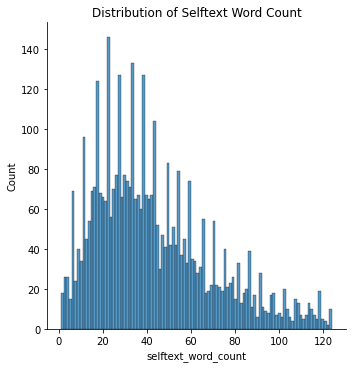

In [879]:
sns.displot(df['selftext_word_count'], kind = 'hist', bins = 100).set(title="Distribution of Selftext Word Count");

### Summarizing Statistics

In [836]:
df.groupby(by='subreddit')['selftext_word_count'].describe().T

subreddit,OutOfTheLoop,explainlikeimfive
count,2155.000000,1843.000000
mean,45.196288,40.510581
std,26.784847,26.155039
min,1.000000,1.000000
25%,25.000000,20.000000
50%,40.000000,35.000000
75%,60.000000,55.000000
max,123.000000,124.000000


In [876]:
df['selftext_word_count'].describe()

count    3998.000000
mean       43.036268
std        26.595863
min         1.000000
25%        23.000000
50%        38.000000
75%        58.000000
max       124.000000
Name: selftext_word_count, dtype: float64

In [837]:
# commenting code to not mess with dataset (already saved)
# df.to_csv('../data/subreddit_EDA.csv')
# df.to_csv('../data/../data/subreddit_cleaned_.csv')